## Fetal Immune Atlas - save labels in anndata

In this notebook I load the raw merged anndata file and add the labels unified in `20201230_UniformCellLabels.ipynb`, fixing some inconsistencies on cell names between organs.

In [1]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
from bbknn import bbknn
import scipy

## For geosketch integration
from geosketch import gs, uniform, srs, kmeanspp
from scanorama import transform
from scipy.sparse import csr_matrix, find
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
# from subprocess import Popen
# import sys
from time import time
from datetime import datetime

### Load merged dataset 

In [3]:
merged_raw = sc.read_h5ad('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.h5ad')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
merged_raw.obs['batch'] = [x+y for x,y in zip(merged_raw.obs['organ'],merged_raw.obs['method'])]
merged_raw.obs['bbk'] = [x+y for x,y in zip(merged_raw.obs['donor'],merged_raw.obs['method'])]

Change barcodes for gut cells

In [8]:
def _rename_gut_cells(x):
    if "FCA" not in x:
        x = x.split("_")[8].split('-')[1] + "-1"  + "_" + "_".join(x.split("_")[3:6])
    else: 
        x = x.split("_")[7].split('-')[1] + "-1" + "_" + "_".join(x.split("_")[3:5]) 
    return(x)

obs_names = merged_raw.obs_names.values
gut_ixs = np.where(merged_raw.obs.organ=="GU")[0]
for i in gut_ixs:
    obs_names[i] = _rename_gut_cells(obs_names[i])

merged_raw.obs_names = obs_names

### Add cell type labels

Made uniform in `notebooks/20201230_UniformCellLabels.ipynb`

In [9]:
annot_dir = '/home/jovyan/mount/gdrive/Pan_fetal/annotations/'
annot_df = pd.read_csv(annot_dir + "uniform_labels_full.csv", index_col=0)

In [10]:
# ### WARNING!! There are duplicated indices in the skin dataset, here I am solving the brute force way
# annot_df.loc[annot_df.index[annot_df.index.duplicated(keep=False)],'uniform_label'] = "NEUTROPHIL"
# annot_df.loc[annot_df.index[annot_df.index.duplicated(keep=False)],'cell.labels'] = "Neutrophile"

# annot_df = annot_df[~annot_df.index.duplicated()]

Fix names to make them uniform w dataset

In [11]:
def _translate_obs_names(x, organ):
    if organ in ["sp", 'bm']:
        if "FCA" in x:
            obs_name = x.split("_")[3]+ '-' +x.split("_")[5]
        else:
            obs_name = x
    elif organ in ["ki"]:
        if "FCA" in x:
            obs_name = x.split("_")[0] + "-" + x.split("_")[-1].split('-')[0]
        else:
            obs_name = x
    elif organ in ["li", 'ys']:
        obs_name = x.split("_")[3]+'-'+x.split("_")[4]
    elif organ in ["sk"]:
        obs_name = x.split("-")[2]+'-'+x.split("-")[0]
    elif organ in ["gu"]:
        obs_name = "-".join(x.split("-")[:2]) + "_" + x.split("-")[2]
    else:
        obs_name = x
    return(obs_name)

In [12]:
# annot_df.index = annot_df["old_name"]
annot_df.index = ["GEX".join(x.split("prime")) for x in annot_df.index]
new_name = [_translate_obs_names(annot_df.index[i],annot_df.organ[i]) for i in range(annot_df.shape[0])]

In [13]:
annot_df["old_name"] = annot_df.index
annot_df.index = new_name

In [14]:
## Subset to cells in the adata
annot_df = annot_df.loc[merged_raw.obs_names[merged_raw.obs_names.isin(annot_df.index)]]

In [15]:
new_anno = pd.concat([merged_raw.obs, annot_df[['uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0']]], 1)

In [16]:
merged_raw.obs = new_anno[~new_anno.Sample.isna()].loc[merged_raw.obs_names]

## Add correct metadata

In [14]:
metadata = pd.read_csv("/home/jovyan/mount/gdrive/Pan_fetal/annotations/manifest_clean_120121.csv", index_col=0)

In [19]:
metadata[metadata["SAMPLE.NAME"]=="F37"]

,Sample.lanes,Adult.fetal,SAMPLE.NAME,Developmental_stage,Sort_id,Concatinated.identity,Organ,Sequencing,Procedure,AnnatomicalPart,Processing_method,age,sex,Genome_ref
81,FCAImmP7504909,Fetal,F37,4PCW,TOT,F37_YS_TOT_1,yolkSac,3prime,MEDICAL,Contents,Collagnase,4,female,GRCh38
82,FCAImmP7504910,Fetal,F37,4PCW,TOT,F37_YS_TOT_2,yolkSac,3prime,MEDICAL,Contents,Collagnase,4,female,GRCh38
83,FCAImmP7504911,Fetal,F37,4PCW,TOT,F37_YS_TOT_3,yolkSac,3prime,MEDICAL,Membrane,Collagnase,4,female,GRCh38
84,FCAImmP7504912,Fetal,F37,4PCW,TOT,F37_YS_TOT_4,yolkSac,3prime,MEDICAL,Membrane,Collagnase,4,female,GRCh38
85,FCAImmP7504913,Fetal,F37,4PCW,TOT,F37_YS_TOT_5,yolkSac,3prime,MEDICAL,Membrane,Collagnase,4,female,GRCh38


In [92]:
metadata['method'] = [x.split("prime")[0]+"GEX" if "prime" in x else x for x in metadata["Sequencing"]]

## Rename columns as they are in obs
metadata['donor'] = metadata['SAMPLE.NAME']

In [93]:
clean_metadata = metadata[["Sample.lanes", "Sort_id","age", "method", "donor", "sex", "Processing_method", "AnnatomicalPart"]]
clean_metadata["file"] = clean_metadata['Sample.lanes']

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [94]:
merged_raw.obs["file"] = ["_".join(x.split("_")[3:]).split("_GRCh")[0] if "cellranger" in x else x for x in merged_raw.obs["file"]]
merged_raw.obs = merged_raw.obs.drop(["sort", "method"],1)
new_obs = merged_raw.obs.reset_index().merge(clean_metadata, on=['file', "donor"], how='left', indicator=True)
new_obs = new_obs.set_index("index")

## Check that the merge has worked properly
if not new_obs.shape[0] == merged_raw.obs.shape[0]:
    print("--- WARNING!! The new obs has more rows than the old obs ---")

if np.any(new_obs._merge=="right_only"):
    print("--- WARNING!! Some values are unique to metadata ---")

if not new_obs.index.is_unique:
    print("--- WARNING!! Duplicate indices ---")
    


Change organ nomenclature for Mesenteric Lymphnodes

In [119]:
new_obs['organ'] = new_obs.organ.astype("str")
new_obs.loc[new_obs.index[new_obs.AnnatomicalPart=="MLN"],'organ'] = "MLN"

In [125]:
new_obs = new_obs.drop(["_merge"],1)

In [126]:
new_obs.to_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.csv")

---
## Visualizing experimental design

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(tidyverse)
library(ggplot2)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [4]:
new_obs = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.csv')

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [76]:
df = new_obs[['uniform_label_lvl0', "uniform_label_expanded_merged","Sample", 'organ']].groupby(["uniform_label_lvl0","uniform_label_expanded_merged","organ"]).count() \
    .unstack(fill_value=0).stack().reset_index()
df.columns[2] 

'organ'

In [97]:
%%R -i df -w 1000 -h 1300
library(patchwork)

p1 <- df %>% 
rename(count=Sample) %>%
ggplot(aes(uniform_label_expanded_merged, count, fill=organ)) +
geom_col(position="fill") +
# scale_y_continuous(trans='log10') +
scale_fill_brewer(palette="Spectral") +
coord_flip() +
facet_grid(uniform_label_lvl0~., space="free", scales="free") +
theme_bw(base_size=14) +
ylab("fraction") +
theme(strip.background = element_blank(),
  strip.text.y = element_blank()) 

p2 <- df %>%
rename(count=Sample) %>%
group_by(uniform_label_expanded_merged, uniform_label_lvl0) %>%
summarise(tot_count=sum(count)) %>%
ggplot(aes(uniform_label_expanded_merged, tot_count)) +
geom_col() +
scale_y_continuous(trans='log10') +
scale_fill_brewer(palette="Spectral") +
coord_flip() +
facet_grid(uniform_label_lvl0~., space="free", scales="free") +
theme_bw(base_size=14) +
theme(strip.text.y=element_text(angle=0), axis.text.y=element_blank(),
     axis.ticks.y=element_blank(), axis.title.y=element_blank()) 

`summarise()` has grouped output by 'uniform_label_expanded_merged'. You can override using the `.groups` argument.


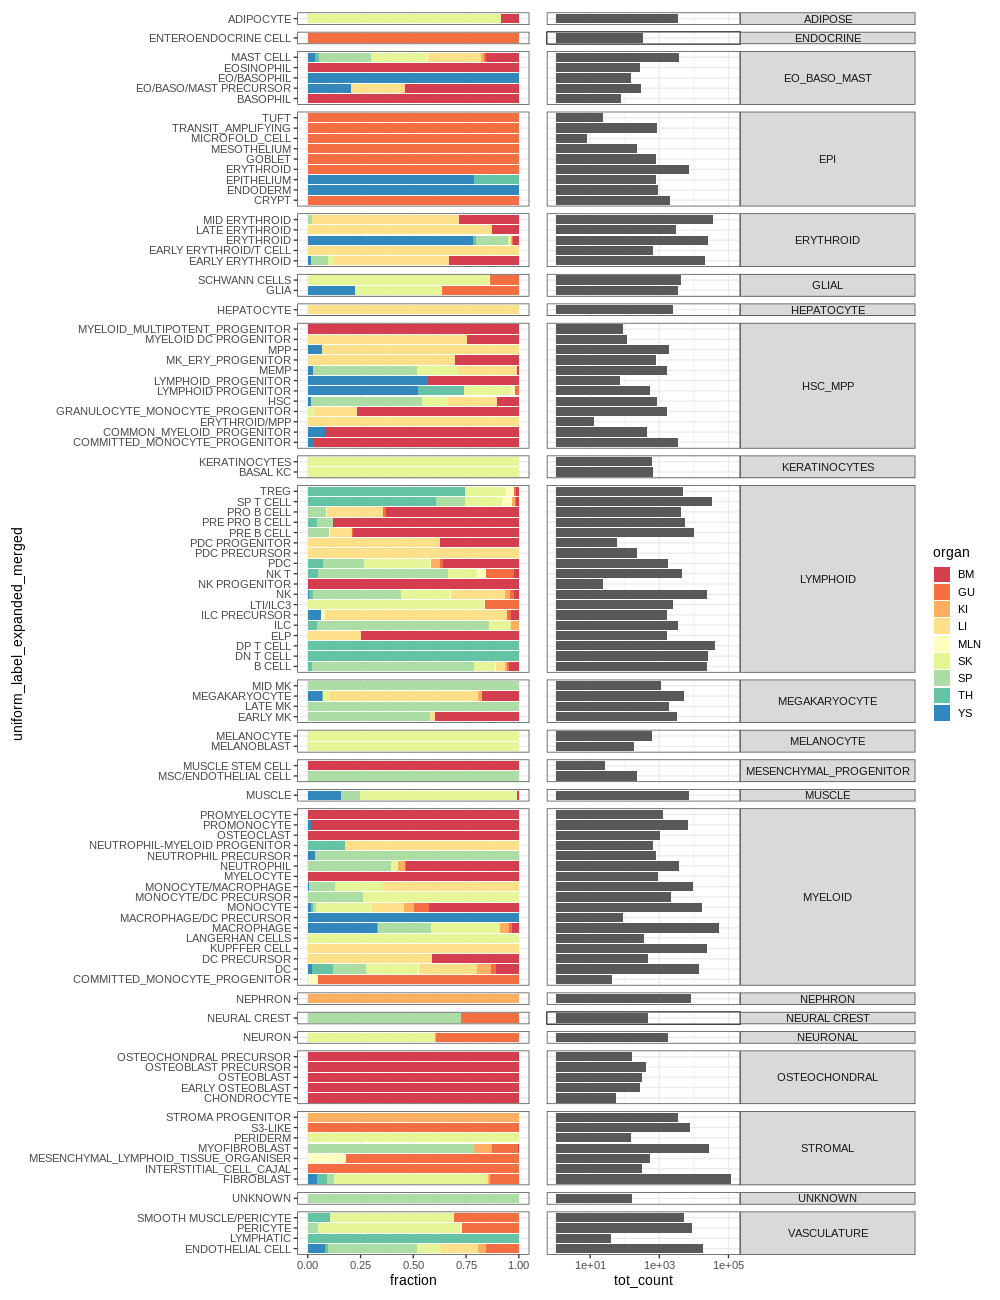

In [102]:
%%R -w 1000 -h 1300
p1 + p2 +
plot_layout(guides="collect", widths=c(1.2,1)) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/uniform_labels_plot.pdf", width=14, height=16) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/uniform_labels_plot.png", width=14, height=16)

In [116]:
donor_count = new_obs.reset_index()[["organ", "donor", "index"]].groupby(["donor", "organ"]).count().reset_index()


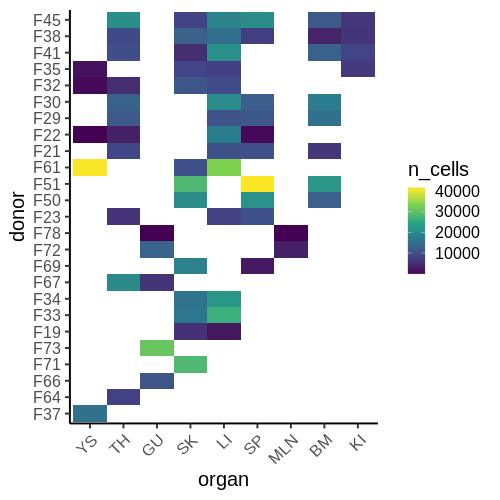

In [126]:
%%R -i donor_count -w 500 -h 500

donor_count %>%
rename(n_cells=index) %>%
mutate(organ=ifelse(organ=="TH(pharyn)", "TH", organ)) %>%
group_by(donor) %>%
mutate(n_organs=n()) %>%
ungroup() %>%
arrange(n_organs) %>%
mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(organ, donor, fill=n_cells)) +
geom_tile() +
theme_classic(base_size=20) +
theme(axis.text.x=element_text(angle=45, hjust=1)) +
scale_fill_viridis_c() +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/donor_organ_plot.pdf", width=7, height=8) +
ggsave("~/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/dataset_meta/donor_organ_plot.png", width=7, height=8)

In [123]:
new_obs["donor"].unique().shape

(25,)

In [66]:
age_count = new_obs.reset_index()[["Sample", "organ", "donor", 'age',"index"]].groupby(["Sample", "donor", "organ", 'age']).count().reset_index()


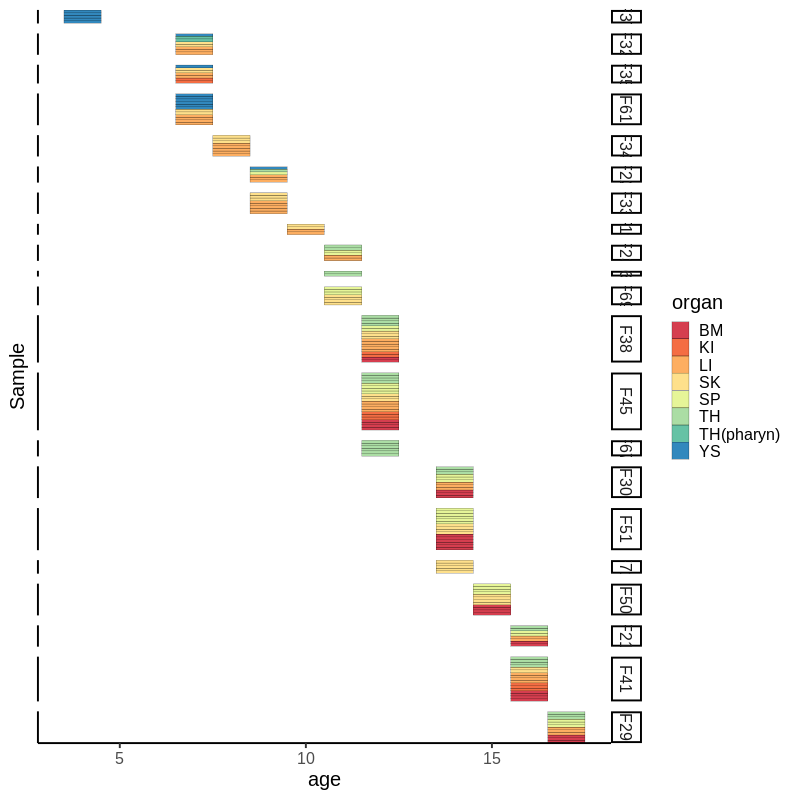

In [105]:
%%R -i age_count -w 800 -h 800

age_count %>%
rename(n_cells=index) %>%
arrange(age, donor, organ) %>%
mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(Sample = factor(Sample, levels=unique(Sample))) %>%
# mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(age, Sample, fill=organ)) +
geom_tile(color='black') +
theme_classic(base_size=20) +
scale_fill_brewer(palette="Spectral") +
theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) +
facet_grid(donor~., scales="free", space="free")


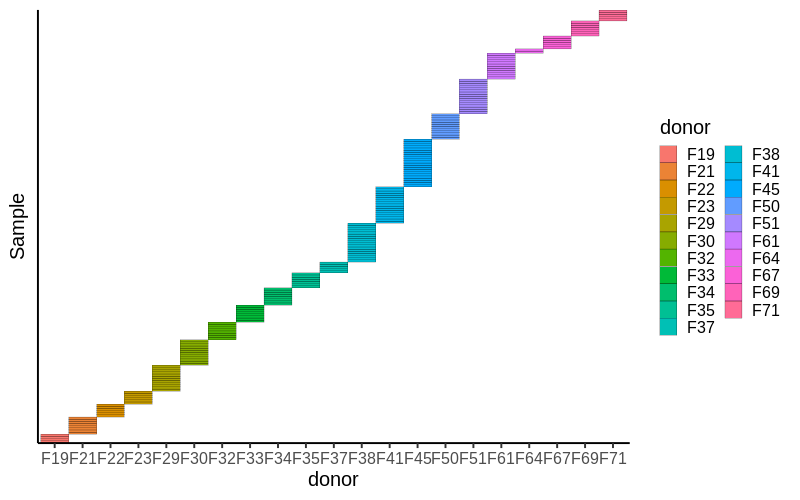

In [96]:
%%R -i age_count -w 800 -h 500

age_count %>%
rename(n_cells=index) %>%
arrange(donor, organ) %>%
# mutate(donor = factor(donor, levels=unique(donor))) %>%
mutate(Sample = factor(Sample, levels=unique(Sample))) %>%
# mutate(organ = factor(organ, levels=unique(organ))) %>%
ggplot(aes(donor, Sample, fill=donor)) +
geom_tile(color='black') +
theme_classic(base_size=20) +
theme(axis.text.y=element_blank(), axis.ticks.y=element_blank())  


In [106]:
merged_raw

NameError: name 'merged_raw' is not defined

In [2]:
import pandas as pd
new_obs = pd.read_csv("/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.wGut.full_obs.csv")

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
%%R -i new_obs
head(new_obs)

KeyboardInterrupt: 

In [ ]:
%%R
new_obs %>%
    group_by()
ggplot(new_obs, aes(age, organ))

In [ ]:
import seaborn as sns
sns.pointplot(data=new_obs)

In [13]:
new_obs.groupby(['donor', 'organ', 'age']).count()

index  Sample  n_counts  n_genes   file   mito  \
donor organ age                                                   
F19   LI    10    1942    1942      1942     1942   1942   1942   
      SK    10    5605    5605      5605     5605   5605   5605   
F21   BM    16    6274    6274      6274     6274   6274   6274   
      LI    16   10093   10093     10093    10093  10093  10093   
      SP    16    9957    9957      9957     9957   9957   9957   
...                ...     ...       ...      ...    ...    ...   
F72   GU    16   13289   13289     13289    13289  13289  13289   
      MLN   16    3039    3039      3039     3039   3039   3039   
F73   GU    15   30876   30876     30876    30876  30876  30876   
F78   GU    17      36      36        36       36     36     36   
      MLN   17      13      13        13       13     13     13   

                 doublet_scores  predicted_doublets   name  batch    bbk  \
donor organ age                                                            
F19   LI    10             1942                1942   1942   1942   1942   
      SK    10             5605                5605   5605   5605   5605   
F21   BM    16             6274                6274   6274   6274   6274   
      LI    16            10093               10093  10093  10093  10093   
      SP    16             9957                9957   9957   9957   9957   
...                         ...                 ...    ...    ...    ...   
F72   GU    16            13289               13289  13289  13289  13289   
      MLN   16             3039                3039   3039   3039   3039   
F73   GU    15            30876               30876  30876  30876  30876   
F78   GU    17               36                  31     36     36     36   
      MLN   17               13                  13     13     13     13   

                 uniform_label  uniform_label_expanded_merged  \
donor organ age                                                 
F19   LI    10               0                              0   
      SK    10            5149                           5149   
F21   BM    16            3119                           3119   
      LI    16            6653                           6653   
      SP    16            6599                           6599   
...                        ...                            ...   
F72   GU    16           11896                          11896   
      MLN   16            2877                           2877   
F73   GU    15           27344                          27344   
F78   GU    17              29                             29   
      MLN   17               2                              2   

                 uniform_label_lvl0  Sample.lanes  Sort_id  method    sex  \
donor organ age                                                             
F19   LI    10                    0          1942     1942    1942   1942   
      SK    10                 5149          5605     5605    5605   5605   
F21   BM    16                 3119          6274     6274    6274   6274   
      LI    16                 6653         10093    10093   10093  10093   
      SP    16                 6599          9957     9957    9957   9957   
...                             ...           ...      ...     ...    ...   
F72   GU    16                11896         13289    13289   13289      0   
      MLN   16                 2877          3039     3039    3039      0   
F73   GU    15                27344         30876    30876   30876  30876   
F78   GU    17                   29            36       36      36      0   
      MLN   17                    2            13       13      13      0   

                 Processing_method  AnnatomicalPart  
donor organ age                                      
F19   LI    10                1942             1942  
      SK    10                5605             5605  
F21   BM    16                6274             6274  
      LI    16               10093    

In [11]:
new_obs.columns

Index(['index', 'Sample', 'n_counts', 'n_genes', 'donor', 'organ', 'file',
       'mito', 'doublet_scores', 'predicted_doublets', 'name', 'batch', 'bbk',
       'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0',
       'Sample.lanes', 'Sort_id', 'age', 'method', 'sex', 'Processing_method',
       'AnnatomicalPart'],
      dtype='object')